<a href="https://colab.research.google.com/github/yuuuuzhang/miniGPT/blob/main/miniGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import packages

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import nltk
from collections import Counter


## Model

In [ ]:
# Position encoding
class myPositionEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=1000):
        # max_len: Maximum length of input sequences (default is 1000 for large sequences).
        super(myPositionEncoding, self).__init__()

        # Calculate positional encodings using sine and cosine functions
        position = torch.arange(0, max_len).unsqueeze(1).float()  # position values. (max_len, 1)

        embedding_index = torch.arange(0, embed_dim, 2).unsqueeze(0).float()  # even indices only
        div_term = 1 / torch.tensor(10000.0) ** (embedding_index / embed_dim)  # (embed_dim//2,)

        positionencoding = torch.zeros(max_len, embed_dim)
        # Apply sine to even indices and cosine to odd indices
        positionencoding[:, 0::2] = torch.sin(position * div_term)  # Apply sine to even indices
        positionencoding[:, 1::2] = torch.cos(position * div_term)  # Apply cosine to odd indices
        positionencoding = positionencoding.unsqueeze(0) # add batch dim, (batch, seq_len, embed_dim)
        self.register_buffer('positionencoding', positionencoding)

    def forward(self, x):
        # Input x shape: (batch_size, seq_len, embed_dim)
        # return: Embeddings with positional encodings added

        # Get the sequence length from the input tensor (x)
        seq_len = x.size(1)

        # Add the positional encoding (broadcasted to the batch size)
        return x + self.positionencoding[:seq_len, :]

# multi head attention layer
class myMultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(myMultiHeadAttention, self).__init__()

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        #sanity check
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"

        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.fc_out = nn.Linear(embed_dim, embed_dim)

    def forward(self, x, mask=None):
        # Input x shape: (batch_size, seq_len, embed_dim)
        # return: projected attention score

        batch_size, seq_len, _ = x.size()

        # Linear projections for query, key, and value
        query = self.query(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        key = self.key(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        value = self.value(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        # Scaled dot-product attention
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(self.head_dim) # Q * t(K) / d_k**1/2: (batch_size, num_heads, seq_len, head_dim) * (batch_size, num_heads, head_dim, seq_len) -> (batch_size, num_heads, seq_len, seq_len)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float("-inf")) # Mask out the positions where mask == 0 with -inf, (batch_size, num_heads, seq_len, seq_len)

        attn_weights = torch.softmax(scores, dim=-1) # softmax(Q * t(K) / d_k**1/2 + M), (batch_size, num_heads, seq_len, seq_len)

        # Combine attention weights with value vectors
        attn_output = torch.matmul(attn_weights, value) # softmax(Q * t(K) / d_k**1/2 + M) * V: shape: (batch_size, num_heads, seq_len, seq_len) * (batch_size, num_heads, seq_len, head_dim) -> (batch_size, num_heads, seq_len, head_dim)

        # Concatenate heads
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.embed_dim) # (batch_size, seq_len, embed_dim)

        # Final linear layer
        return self.fc_out(attn_output) # (batch_size, seq_len, embed_dim)

# Feedforward Network
class myFeedForward(nn.Module):
    def __init__(self, embed_dim, hidden_dim):
        super(myFeedForward, self).__init__()
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, embed_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Input x shape: (batch_size, seq_len, embed_dim)
        # return: refined the token representations
        return self.fc2(self.relu(self.fc1(x)))  # (batch_size, seq_len, embed_dim)

# Transformer decoder part
class myTransformerDecoder(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim, max_len):
        super(myTransformerDecoder, self).__init__()
        self.attention = myMultiHeadAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.feed_forward = myFeedForward(embed_dim, hidden_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x, mask):
        # Input x shape: (batch_size, seq_len, embed_dim)
        # Input mask: Attention mask of shape (batch_size, seq_len, seq_len)
        # return: refined layer normalized residual connection

        attn_output = self.attention(x, mask)  # (batch_size, seq_len, embed_dim)
        x = self.norm1(x + attn_output)  # (batch_size, seq_len, embed_dim)
        ff_output = self.feed_forward(x)  # (batch_size, seq_len, embed_dim)
        return self.norm2(x + ff_output)  # (batch_size, seq_len, embed_dim)

# mini GPT Model
class miniGPTModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, hidden_dim, max_len):
        super(miniGPTModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim) # (batch_size, seq_len) -> (batch_size, seq_len, embed_dim)
        self.positionencoding = myPositionEncoding(embed_dim, max_len) # (batch_size, seq_len, embed_dim)
        self.layers = nn.ModuleList([
            myTransformerDecoder(embed_dim, num_heads, hidden_dim, max_len) for _ in range(num_layers)
        ])
        self.fc_out = nn.Linear(embed_dim, vocab_size)

    def forward(self, x, mask):
        # Input x shape: (batch_size, seq_len, embed_dim)
        # Input mask: Attention mask of shape (batch_size, seq_len, seq_len)
        # return: predicted token probability

        # Embedding and positional encoding
        x = self.embedding(x)  # (batch_size, seq_len, embed_dim)
        x = self.positionencoding(x)  # Add positional encodings, (batch_size, seq_len, embed_dim)

        # Pass through all transformer decoder layers
        for layer in self.layers:
            x = layer(x, mask)  # (batch_size, seq_len, embed_dim)

        # Project to vocab size
        return self.fc_out(x)  # (batch_size, seq_len, vocab_size)

# Mask function
def create_mask(seq_len):
    return torch.tril(torch.ones((seq_len, seq_len))).unsqueeze(0).unsqueeze(0)  # (1, 1, seq_len, seq_len)

## Generate data

In [ ]:
# Download NLTK data
nltk.download('punkt')

# Sample text (replace with your own corpus)
text = "Deep learning is a type of machine learning that uses artificial neural networks to teach computers to process data."

# Tokenize the text into words
tokens = nltk.word_tokenize(text.lower())  # Lowercase all words for simplicity

# Build vocabulary (unique tokens)
vocab = Counter(tokens)

# Create a mapping from token to index
vocab_size = len(vocab)
token_to_idx = {token: idx for idx, (token, _) in enumerate(vocab.items())}

# Create a mapping from index to token
idx_to_token = {idx: token for token, idx in token_to_idx.items()}

# Print the vocabulary
print("Vocabulary:", vocab)

# Convert text tokens into their integer IDs
token_ids = [token_to_idx[token] for token in tokens if token in token_to_idx]

print("Token IDs:", token_ids)


Vocabulary: Counter({'learning': 2, 'to': 2, 'deep': 1, 'is': 1, 'a': 1, 'type': 1, 'of': 1, 'machine': 1, 'that': 1, 'uses': 1, 'artificial': 1, 'neural': 1, 'networks': 1, 'teach': 1, 'computers': 1, 'process': 1, 'data': 1, '.': 1})
Token IDs: [0, 1, 2, 3, 4, 5, 6, 1, 7, 8, 9, 10, 11, 12, 13, 14, 12, 15, 16, 17]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Parameters

In [ ]:
# Parameters
seq_len = 10  # Define sequence length
batch_size = 32
vocab_size = len(vocab)
embed_dim = 64
hidden_dim = 128
num_heads = 4
num_layers = 2
num_epochs = 20
lr = 0.001

## Prepare training and test data

In [ ]:
inputs = []
targets = []

# Generate sequences of tokens and their corresponding target tokens
for i in range(len(token_ids) - seq_len):
    inputs.append(token_ids[i:i + seq_len])   # Input sequence of fixed length
    targets.append(token_ids[i + 1:i + seq_len + 1])  # Target sequence (shifted by one token)

inputs = torch.tensor(inputs)  # (num_samples, seq_len)
targets = torch.tensor(targets)  # (num_samples, seq_len)

print("Inputs shape:", inputs.shape)
print("Targets shape:", targets.shape)

# Split into training and test data (80% for training, 20% for testing)
train_inputs, test_inputs, train_targets, test_targets = train_test_split(inputs, targets, test_size=0.2, shuffle=True)

# Print the shapes of training and test data
print("Train Inputs shape:", train_inputs.shape)
print("Train Targets shape:", train_targets.shape)
print("Test Inputs shape:", test_inputs.shape)
print("Test Targets shape:", test_targets.shape)

# Create DataLoader for training
train_dataset = TensorDataset(train_inputs, train_targets)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for testing
test_dataset = TensorDataset(test_inputs, test_targets)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print the first batch from the DataLoader
for batch_inputs, batch_targets in train_dataloader:
    print("Batch Inputs:", batch_inputs)
    print("Batch Targets:", batch_targets)
    break


Inputs shape: torch.Size([10, 10])
Targets shape: torch.Size([10, 10])
Train Inputs shape: torch.Size([8, 10])
Train Targets shape: torch.Size([8, 10])
Test Inputs shape: torch.Size([2, 10])
Test Targets shape: torch.Size([2, 10])
Batch Inputs: tensor([[ 7,  8,  9, 10, 11, 12, 13, 14, 12, 15],
        [ 0,  1,  2,  3,  4,  5,  6,  1,  7,  8],
        [ 2,  3,  4,  5,  6,  1,  7,  8,  9, 10],
        [ 6,  1,  7,  8,  9, 10, 11, 12, 13, 14],
        [ 1,  2,  3,  4,  5,  6,  1,  7,  8,  9],
        [ 8,  9, 10, 11, 12, 13, 14, 12, 15, 16],
        [ 5,  6,  1,  7,  8,  9, 10, 11, 12, 13],
        [ 4,  5,  6,  1,  7,  8,  9, 10, 11, 12]])
Batch Targets: tensor([[ 8,  9, 10, 11, 12, 13, 14, 12, 15, 16],
        [ 1,  2,  3,  4,  5,  6,  1,  7,  8,  9],
        [ 3,  4,  5,  6,  1,  7,  8,  9, 10, 11],
        [ 1,  7,  8,  9, 10, 11, 12, 13, 14, 12],
        [ 2,  3,  4,  5,  6,  1,  7,  8,  9, 10],
        [ 9, 10, 11, 12, 13, 14, 12, 15, 16, 17],
        [ 6,  1,  7,  8,  9, 10, 11, 12

## Training and test

In [ ]:
# Initialize model, loss, and optimizer
model = miniGPTModel(vocab_size, embed_dim, num_heads, num_layers, hidden_dim, seq_len)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr)

# Track metrics
train_losses = []
test_accuracies = []

# Training and testing loop
for epoch in range(num_epochs):
    # Training
    model.train()
    total_loss = 0
    for x, y in train_dataloader:
        optimizer.zero_grad()  # Clear gradients

        gpt_mask = create_mask(x.size(1))  # Create a mask with the current sequence length

        # Forward pass with both input_ids and mask
        outputs = model(x, gpt_mask)  # Forward pass

        loss = criterion(outputs.view(-1, vocab_size), y.view(-1))  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    # print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}")

    # Testing
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in test_dataloader:
            gpt_mask = create_mask(x.size(1))  # Create a mask with the sequence length of the test batch

            outputs = model(x, gpt_mask) # Forward pass
            predictions = torch.argmax(outputs, dim=-1)  # Get predicted tokens
            correct += (predictions == y).sum().item()  # Count correct predictions
            total += y.numel()  # Total tokens

    accuracy = correct / total
    test_accuracies.append(accuracy)
    # print(f"Epoch {epoch + 1}/{num_epochs}, Test Accuracy: {accuracy:.4f}")


## Visualisation

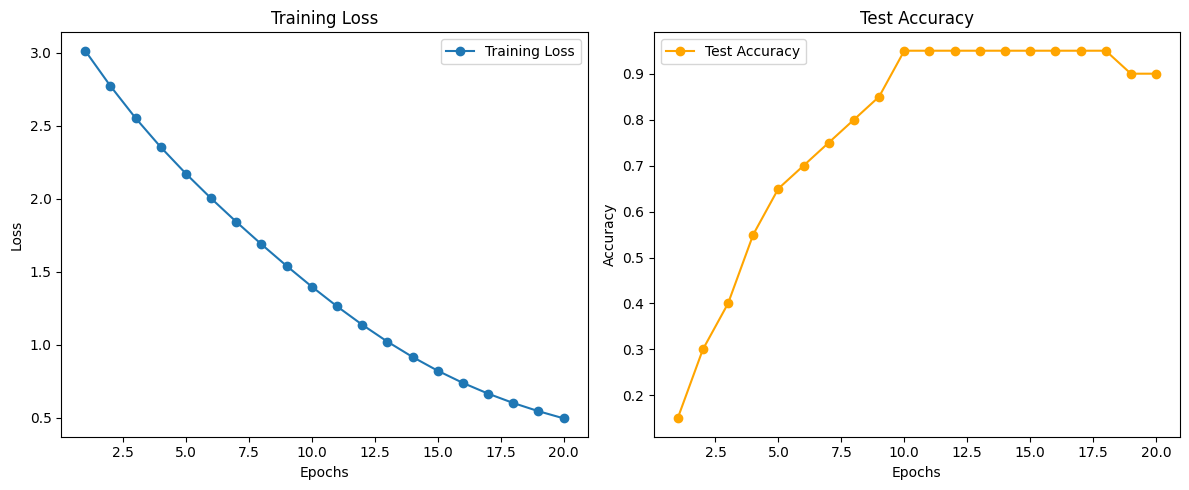

In [ ]:
# Plot training loss and test accuracy
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

# Training Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Training Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

# Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, test_accuracies, label="Test Accuracy", marker='o', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Test Accuracy")
plt.legend()

plt.tight_layout()
plt.show()
